In [ ]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 26397 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...


In [ ]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [ ]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
## This is not working for IU
## Load the Drive helper and mount
#from google.colab import drive

## This will prompt for authorization.
#drive.mount('/content/gdrive')

In [ ]:
!pip3 install torch torchvision librosa

    100% |████████████████████████████████| 519.5MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59542000 @  0x7fc84e68e2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 22.3MB/s 
    100% |████████████████████████████████| 1.6MB 4.4MB/s 
    100% |████████████████████████████████| 2.0MB 3.9MB/s 
    100% |████████████████████████████████| 327kB 4.7MB/s 
    100% |████████████████████████████████| 3.2MB 3.1MB/s 
    100% |████████████████████████████████| 16.1MB 1.5MB/s 
  Running setup.py bdist_wheel for librosa ... done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... done
  Stored in directory: /root/.c

In [65]:
SERVER = False

# Files and Directories
ROOT_DIR = "drive/SIV-Project/"
TRAIN_PATH = 'wav_train_subset'
STFT_FOLDER = 'stft'
PAIRS_FILE = 'pairs.csv'
VGG_VOX_WEIGHT_FILE = "vggvox_ident_net.mat"

# Data_Part
TOTAL_USERS = 100
CLIPS_PER_USER = 10
MIN_CLIP_DURATION = 3.

# ML_Part
SIMILAR_PAIRS = 20
DISSIMILAR_PAIRS = SIMILAR_PAIRS
TRAINING_USERS = 40

assert SIMILAR_PAIRS <= CLIPS_PER_USER * (CLIPS_PER_USER - 1)
# print("len of pairs.csv should be", (SIMILAR_PAIRS + DISSIMILAR_PAIRS) * TOTAL_USERS)


from tqdm import tqdm
import os
import time
import itertools
from collections import Counter
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import scipy
import sklearn
import librosa
import librosa.display
import wave
import contextlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader


def get_rel_path(path, server=SERVER, root_dir=ROOT_DIR):
    if server:
        return os.path.join(root_dir, path)
    else:
        return path


def wavPlayer(filepath):
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>

    <body>
    <audio controls="controls" style="width:600px" >
      <source src="%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

In [42]:
def get_clip_duration(fname):
#     all_durations = []
#     for fname in tqdm(all_user_clips):
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
#             all_durations.append(duration)
#     all_durations = np.array(all_durations)
    return duration

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
train_user_ids = os.listdir(get_rel_path(TRAIN_PATH))

In [45]:
def get_user_clips(clips_per_user=CLIPS_PER_USER):
    ### all_user_clips is list of clips representing user and their list of clips
    all_user_clips = []
    
    with open(get_rel_path('clips_list.txt'), 'r') as f:
        for line in tqdm(f):
            paths = line.split()
            paths = [get_rel_path("/".join(p.split("/")[2:])) 
                     for p in paths]
            paths = [p for p in paths if get_clip_duration(p) > MIN_CLIP_DURATION]
            if len(paths) < CLIPS_PER_USER:
                continue
                
            assert len(paths) > CLIPS_PER_USER 
            all_user_clips.extend(paths[: clips_per_user])
        
#     assert len(Counter(all_user_clips)) > 1
    return all_user_clips

In [46]:
all_user_clips = get_user_clips()
print(len(all_user_clips), "clips")

100it [00:01, 98.71it/s]

1000 clips


In [47]:
all_durations = np.array([get_clip_duration(p) for p in all_user_clips])
assert all_durations.min() > MIN_CLIP_DURATION

In [48]:
def get_waveform(clip_list, offset=0., duration=MIN_CLIP_DURATION):
    all_x = []
    all_sr = []
    for path in tqdm(clip_list):
        x, sr = librosa.load(path, sr=None, offset=offset, 
                             duration=duration)
        all_x.append(x)
        all_sr.append(sr)
        
    assert len(np.unique(np.array(all_sr))) == 1
    return all_x, all_sr

In [49]:
all_x, all_sr = get_waveform(all_user_clips)

100%|██████████| 1000/1000 [00:05<00:00, 198.03it/s]


In [50]:
assert len(np.unique(np.array([x.shape[0] for x in all_x]))) == 1, str(len(np.unique(np.array([x.shape[0] for x in all_x]))))

In [51]:
def get_stft(all_x, nperseg=400, noverlap=239, nfft=1023):
    all_stft = []
    for x in tqdm(all_x):
        _, _, Z = scipy.signal.stft(x, window="hamming", 
                                       nperseg=nperseg,
                                       noverlap=noverlap,
                                       nfft=nfft)
        Z = sklearn.preprocessing.normalize(np.abs(Z), axis=1)        
        assert Z.shape[0] == 512
        all_stft.append(Z)
    
    return np.array(all_stft)

In [52]:
all_stft = get_stft(all_x)
print(all_stft[0].shape)

100%|██████████| 1000/1000 [00:06<00:00, 141.27it/s]


(512, 300)


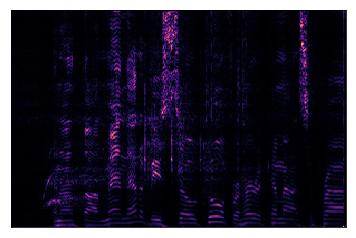

In [53]:
librosa.display.specshow(all_stft[0], sr=all_sr[0])
plt.show()

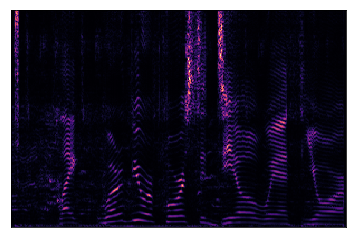

In [54]:
librosa.display.specshow(all_stft[-2], sr=all_sr[0])
plt.show()

In [55]:
def save_stft(all_stft, all_user_clips):
    all_stft_paths = []
    for i, user_path in tqdm(enumerate(all_user_clips)):
        user_stft = all_stft[i]
        stft_fname = '_'.join(user_path.split('/')[-3:])[:-4] + '.npy'
        stft_path = get_rel_path(os.path.join(STFT_FOLDER, stft_fname))
        np.save(stft_path, user_stft)
        all_stft_paths.append(stft_path)
    return all_stft_paths

In [56]:
stft_paths = save_stft(all_stft, all_user_clips)

1000it [00:03, 325.40it/s]


In [57]:
stft_paths[0]

'stft/id10095_8TXDdU7D-z8_00001.npy'

In [58]:
data = list(itertools.product(stft_paths, stft_paths))
df = pd.DataFrame(data, columns=["path1", "path2"])
df = df[~(df.path1 == df.path2)]  # to drop samples when path1 and path2 are same

In [62]:
df['user1'] = df['path1'].apply(lambda x: x[x.find('/')+1: x.find('_')])
df['user2'] = df['path2'].apply(lambda x: x[x.find('/')+1: x.find('_')])
df['label'] = (df.user1 == df.user2).astype('int')
df['label'] = np.abs(df.label - 1)
print("Total unique users", df.user1.nunique()) 
assert df.user1.nunique() == TOTAL_USERS
assert df.user2.nunique() == TOTAL_USERS
print("len", len(df))
df.sample(5)

Total unique users 100
len 999000


,path1,path2,user1,user2,label
398155,stft/id10067_LWet2zhWjBg_00030.npy,stft/id10081_RiDE7jQNGew_00001.npy,id10067,id10081,1
697679,stft/id10031_s4BZz4_ieIc_00008.npy,stft/id10036_NP3WmxUdvnI_00003.npy,id10031,id10036,1
985601,stft/id10003_yzIXg93UOIM_00014.npy,stft/id10040_Cu1Gugj18Vg_00004.npy,id10003,id10040,1
934458,stft/id10001_J9lHsKG98U8_00019.npy,stft/id10052_fi3V4OzrkaA_00010.npy,id10001,id10052,1
331393,stft/id10068_DfhPg3rmKv0_00005.npy,stft/id10067_8p_WkPwuhGA_00003.npy,id10068,id10067,1


In [63]:
df.label.value_counts()

1    990000
0      9000
Name: label, dtype: int64

In [ ]:
# pairs_df = []
# for user in df.user1.unique():
#     user_df = df[df.user1 == user]
#     similar = user_df[user_df['label'] == 0].sample(n=SIMILAR_PAIRS)
#     dissimilar = user_df[user_df['label'] == 1].sample(n=DISSIMILAR_PAIRS)
#     pairs_df.append(pd.concat([similar, dissimilar]))

# pairs_df = pd.concat(pairs_df)
# assert len(pairs_df) == (SIMILAR_PAIRS + DISSIMILAR_PAIRS) * TOTAL_USERS

In [ ]:
# print(len(pairs_df))
# pairs_df.head()

In [64]:
pairs_df = df

In [67]:
pairs_df.to_csv(PAIRS_FILE, index=False)